<a href="https://colab.research.google.com/github/anabeatrizzdm/MLPSentimentosIMDB/blob/main/MLPsentimentosimdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ana Beatriz Dias Mendes
RA: 22353494

## Imports, instalação de pacotes, download de dados necessários e configurações

In [ ]:
import re

import torch
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.neural_network import MLPClassifier
from torch import nn

In [ ]:
!pip install -q gdown

In [ ]:
!gdown --id 1aB3ACvT8kD7AINAkkUbYz9qherwLFd8z -O dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1aB3ACvT8kD7AINAkkUbYz9qherwLFd8z
From (redirected): https://drive.google.com/uc?id=1aB3ACvT8kD7AINAkkUbYz9qherwLFd8z&confirm=t&uuid=86edd4f8-e42e-46cb-ab7f-bd34545966a4
To: /content/dataset.zip
100% 50.8M/50.8M [00:01<00:00, 31.7MB/s]


In [ ]:
!unzip dataset.zip

Archive:  dataset.zip
replace imdb-reviews-pt-br.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
nltk.download("stopwords")
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
tqdm.pandas()

pd.set_option("display.max_colwidth", 0)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Reconhecimento de digitos escritos a mão (MNIST)

## constantes

In [ ]:
INPUT_SIZE = 28*28
NUM_CLASSES = 10

## carregamento e tratamento de dados

In [ ]:
def normalize(X):
    return ((X - 128) / 255.0).astype(np.float32)

In [ ]:
data = pd.read_csv("sample_data/mnist_train_small.csv").values
data_test = pd.read_csv("sample_data/mnist_test.csv").values

In [ ]:
y_i, X_i = data[:, 0], data[:, 1:]
y_i_test, X_i_test = data_test[:, 0], data_test[:, 1:]

X_i, X_i_test = normalize(X_i), normalize(X_i_test)

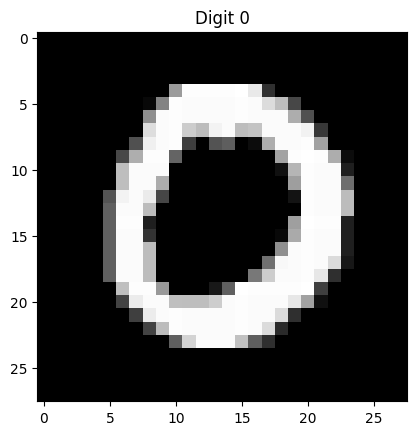

In [ ]:
idx = np.random.randint(len(X_i_test))
plt.imshow(X_i_test[idx].reshape((28, 28)), cmap='gray')
plt.title(f"Digit {y_i_test[idx]}")
plt.show()

## Modelo MLP (edite aqui)

## defina seu modelo aqui

utilize `n.Sequential` para criar o modelo passando como argumento uma lista de camadas.

Obs: utilize `nn.Linear(<dimensão de entrada>, <dimensão de saída>)`como camada linear
escolha uma função de ativação (nn.ReLu, nn.Sigmoid, nn.Tanh)

In [ ]:
model = nn.Sequential(
    *[
        nn.Linear(INPUT_SIZE, 100),
        nn.Tanh(),
        nn.Linear(100, NUM_CLASSES)
    ]
).to(device)

## treinamento do modelo

Se baseie no pseudocódigo:

```python
receba modelo, X, y, n_epochs, learning_rate

para cada epoca em n_epochs:
    zere qualquer gradiente anterior

    alimente o modelo com os dados
    
    calcula a função de custo
    
    propaga o custo para trás
    
    aplica um passo de otmização
```

In [ ]:
def train(model, X, y, n_epochs=10000, learning_rate=0.01):
    """
        model(x):
            chama o modelo na entrada x

        nn.functional.cross_entropy(y_predito, y_verdadeiro):
             calcula a entropia cruzada entre predição e ground true
             returna [loss]

        loss.backward():
            propaga os gradientes (backpropagation)

        torch.optim.SGD(model.parameters(), learning_rate):
            [otimizador] gradiente descendente estocástico,
            responsavel por atualizar os pesos daado que os gradientes
            já foram calculados

        torch.optim.AdamW(model.parameters(), learning_rate):
            [otimizador] avançado Adam.
            responsavel por atualizar os pesos daado que os gradientes
            já foram calculados

        [otimizador].zero_grad():
             limpa cálculos anteriores

        [otimizador].step()
            atualiza pesos do modelo dado que os gradientes já foram calculados

    """
    if isinstance(X, np.ndarray):
        X, y = [torch.from_numpy(var).to(device)
                for var in (X, y)]

    optimizer = torch.optim.AdamW(model.parameters(), learning_rate)
    for epoch in tqdm(range(n_epochs)):
      optimizer.zero_grad()

      y_pred = model(X)

      loss = nn.functional.cross_entropy(y_pred, y)
      loss.backward()

      optimizer.step()


In [ ]:
train(model, X_i, y_i)

  0%|          | 0/10000 [00:00<?, ?it/s]

## avaliação

In [ ]:
def predict(model, x):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x.astype(np.float32)).to(device)

    with torch.no_grad():
        y_pred = model(x).argmax(axis=-1)

    return y_pred.cpu().numpy()

y_pred = predict(model, X_i_test)
print(f"A Acurácia do modelo no conjunto que ele não viu foi de "
      f"{100 * accuracy_score(y_i_test, y_pred): .2f}")

A Acurácia do modelo no conjunto que ele não viu foi de  96.29


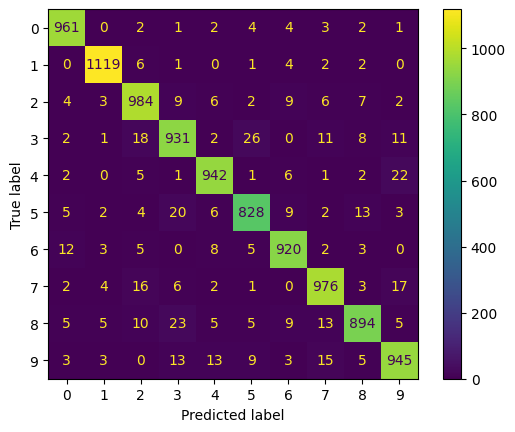

In [ ]:
cm = confusion_matrix(y_i_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()

plt.show()

## teste seu modelo

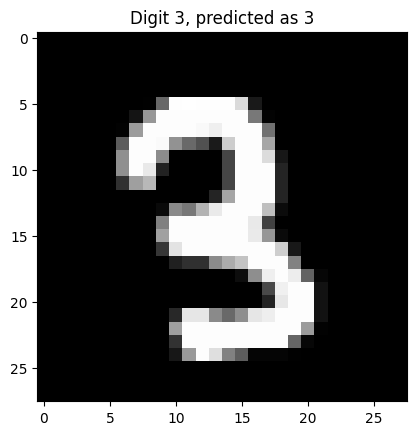

In [ ]:
idx = np.random.randint(len(X_i_test))
y_pred = predict(model, X_i_test[idx])
plt.imshow(X_i_test[idx].reshape((28, 28)), cmap='gray')
plt.title(f"Digit {y_i_test[idx]}, predicted as {y_pred}")
plt.show()

# Análise de sentimentos em avaliações de filmes

## Constante

In [ ]:
INPUT_SIZE = 5000
NUM_CLASSES = 2

## tratamento de dados

In [ ]:
df = pd.read_csv("imdb-reviews-pt-br.csv")
len(df)

49459

In [ ]:
EXEPTIONS = {'não'}
stopwords = set(nltk.corpus.stopwords.words("portuguese")) - EXEPTIONS
stemmer = nltk.stem.rslp.RSLPStemmer()

In [ ]:
df.head(1)

,id,text_en,text_pt,sentiment
0,1,"Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are very few I just did not care about any of the characters. Most of us have ghosts in the closet, and Costners character are realized early on, and then forgotten until much later, by which time I did not care. The character we should really care about is a very cocky, overconfident Ashton Kutcher. The problem is he comes off as kid who thinks hes better than anyone else around him and shows no signs of a cluttered closet. His only obstacle appears to be winning over Costner. Finally when we are well past the half way point of this stinker, Costner tells us all about Kutchers ghosts. We are told why Kutcher is driven to be the best with no prior inkling or foreshadowing. No magic here, it was all I could do to keep from turning it off an hour in.","Mais uma vez, o Sr. Costner arrumou um filme por muito mais tempo do que o necessário. Além das terríveis seqüências de resgate no mar, das quais há muito poucas, eu simplesmente não me importei com nenhum dos personagens. A maioria de nós tem fantasmas no armário, e o personagem Costers é realizado logo no início, e depois esquecido até muito mais tarde, quando eu não me importava. O personagem com o qual deveríamos nos importar é muito arrogante e superconfiante, Ashton Kutcher. O problema é que ele sai como um garoto que pensa que é melhor do que qualquer outra pessoa ao seu redor e não mostra sinais de um armário desordenado. Seu único obstáculo parece estar vencendo Costner. Finalmente, quando estamos bem além do meio do caminho, Costner nos conta sobre os fantasmas dos Kutchers. Somos informados de por que Kutcher é levado a ser o melhor sem pressentimentos ou presságios anteriores. Nenhuma mágica aqui, era tudo que eu podia fazer para não desligar uma hora.",neg


In [ ]:
REPLACEMENTS = [
    (r'@\w+', ''),
    (r'\W', ' '),
    (r'\s+', ' '),
]


def preprocess(text, remove_stopwords=True):
    text = text.lower()

    for pattern, repl in REPLACEMENTS:
        text = re.sub(pattern, repl, text)

    return " ".join([stemmer.stem(word) for word in text.split()
                     if not remove_stopwords or word not in stopwords])


In [ ]:
texts = [preprocess(text) for text in tqdm(df.text_pt)]

  0%|          | 0/49459 [00:00<?, ?it/s]

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(texts)
Y = (df.sentiment == 'pos').astype(int).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

## defina seu modelo aqui e chame a mesma função de treinamento

In [ ]:
model2 = nn.Sequential(
    *[
        nn.Linear(INPUT_SIZE, 100),
        nn.Sigmoid(),
        nn.Linear(100, NUM_CLASSES)
    ]
).to(device)
train(model2, X_train.todense().astype(dtype=np.float32), Y_train, n_epochs=750)

  0%|          | 0/750 [00:00<?, ?it/s]

## avaliação

In [ ]:
y_pred = predict(model2, X_test.todense().astype(np.float32))

print(f"A Acurácia do modelo no conjunto que ele não viu foi de "
      f"{100 * accuracy_score(Y_test, y_pred): .2f}")

A Acurácia do modelo no conjunto que ele não viu foi de  84.71


### utilidade de interface (ignore)

In [ ]:
from IPython.display import display
from ipywidgets import FloatProgress

def show_bar(percentage):
    display(
        FloatProgress(
            value=percentage,
            min=0,
            max=1,
            description='Nível de positividade detectado:',
            bar_style='info',
            style={
                'description_width': 'initial',
                'bar_color': '#ff0000' if percentage < .3
                              else ('#ffff00' if percentage < .6
                                       else '#00ff00')},
            orientation='horizontal'
        )
    )

In [ ]:
def analyse_sentence(sentence):
    probs = nn.functional.softmax(
        model2(
            torch.from_numpy(
                vectorizer.transform(
                    [preprocess(sentence)]
                ).todense().astype(np.float32)
            ).to(device)
        ),
        dim=-1
    )[0]

    print("Essa foi uma critica ruim! 😥" if probs.argmax() == 0 else
          "Essa critica foi boa! 😀")
    show_bar(probs[1])


## teste seu modelo

In [ ]:
analyse_sentence("ótimo filme")

Essa critica foi boa! 😀


FloatProgress(value=1.0, bar_style='info', description='Nível de positividade detectado:', max=1.0, style=Prog…

In [ ]:
analyse_sentence("odiei, pior filme de todos")

Essa foi uma critica ruim! 😥


FloatProgress(value=4.429508771863766e-05, bar_style='info', description='Nível de positividade detectado:', m…

In [ ]:
analyse_sentence("filme sem graça")

Essa foi uma critica ruim! 😥


FloatProgress(value=0.001364203286357224, bar_style='info', description='Nível de positividade detectado:', ma…